In [1]:
import pandas as pd
import os, json, sys, subprocess
from numpy import nan
import numpy as np
from statistics import median
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
DATA_CONVERGE_PROJECT="sd2e-project-43/test/batch_20200525"
base_dir = os.path.join(os.path.expanduser("~"), 'sd2e-projects')
RESULTSDIR = "./20200617"

In [3]:
# # Results file handling if transferred to sd2e-projects

# DATE = "20200423"
# RESULTS ="sd2e-project-45/wasserstein-10-fold/{}".format(DATE)
# datetime = subprocess.check_output(['date +%Y_%m_%d_%H_%M_%S'],shell=True).decode(sys.stdout.encoding).strip()
# base_dir = os.path.join(os.path.expanduser("~"), 'sd2e-projects')
# results_dir = os.path.join(base_dir, RESULTS)
# results_dir_contents = [os.path.realpath(os.path.join(results_dir, x)) for x in os.listdir(results_dir) if "summary" not in x]
# results_dir_short = sorted([r for r in results_dir_contents if "Short" in r])

# results_dir_short

In [4]:
# Local results file handling

datetime = subprocess.check_output(['date +%Y_%m_%d_%H_%M_%S'],shell=True).decode(sys.stdout.encoding).strip()
results_dir = os.path.expanduser(RESULTSDIR)
results_dir_contents = [os.path.realpath(os.path.join(results_dir, x)) for x in os.listdir(results_dir) if "summary" not in x]
results_dir_short = sorted([r for r in results_dir_contents if "Short" in r])

results_dir_short

['/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv',
 '/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv',
 '/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_etl_stats_wasserstein_dists.csv',
 '/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_raw_log10_stats_wasserstein_dists.csv']

In [5]:
# Metadata file handling

exps = [r.split("/") for r in results_dir_short]
experiments = [e.split("_fc")[0] for le in exps for e in le if e.startswith("dc_")]
meta_files = []
for experiment in experiments:
    exp_path = os.path.join(base_dir,DATA_CONVERGE_PROJECT,experiment)
    for fname in os.listdir(exp_path):
        if fname.endswith("_fc_meta.csv"): 
            meta_files.append(os.path.realpath(os.path.join(exp_path,fname)))

meta_files

['/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800/YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800/YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032/YeastSTATES-CRISPR-Short-Duration-Time-Series-35C__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032/YeastSTATES-CRISPR-Short-Duration-Time-Series-35C__fc_meta.csv']

In [6]:
# Helper functions

def load_csv(fname):
    # for both results and combined metadata df
    return pd.read_csv(fname)

def group_me(df,columns):
    # for metadata df
    return df.groupby(columns)

def get_samp_id_order(df):
    # for results df
    return list(df.columns)[1:]

def get_matrix(df):
    #for results df
    return df.values

def get_samp_ids_per_time_point(df,col,value):
    # for group in grouped metadata df
    df2 = df[df[col] == value]
    return df2["sample_id"].values

def get_index_pair_value(results,samp_id_order,id1,id2):
    # for results matrix from results df
    ind1 = samp_id_order.index(id1)
    ind2 = samp_id_order.index(id2)
    return results[ind1,ind2]
    

In [7]:
def compute_time_difference(results_file, metadata_file, columns, comparison_column, comparison_values):
    '''
    results_file = Wasserstein results
    metadata_file = csv with merged metadata columns
    columns = columns to groupby (probably strain, BE conc, and rep)
    comparison_column = column containing the two values to compare
    comparison_values = 2 vector with a start value and an end value
    threshold_10_fold = number above which a minimum of a 10-fold difference is detected (i.e. may want to choose 9.5 instead of 10)
    '''
    meta_df = load_csv(metadata_file)
    meta_grouped = group_me(meta_df,columns)
    res_df = load_csv(results_file)
    samp_id_order = get_samp_id_order(res_df)
    results = get_matrix(res_df)[:,1:]
    values = {}
    missing = []
    for name,group in meta_grouped:
        initial_ids = get_samp_ids_per_time_point(group,comparison_column,comparison_values[0])
        final_ids = get_samp_ids_per_time_point(group,comparison_column,comparison_values[1])
        group_vals = []
        pairs = []
        for samp_id_init in initial_ids:
            for samp_id_fin in final_ids:
                try: 
                    val = get_index_pair_value(results,samp_id_order,samp_id_init,samp_id_fin)
                except:
                    # handle dropped samples in ETL
                    # print("One of the two sample ids {} not found.".format([samp_id_init,samp_id_fin]))
                    val = nan                        
                group_vals.append(val)
                pairs.append((samp_id_init,samp_id_fin))
        if group_vals:
            values[name] = [min(group_vals),median(group_vals),max(group_vals),pairs]
        else:
            missing.append(name)
    summary = pd.DataFrame.from_dict(values, orient='index',columns=['wasserstein_min','wasserstein_median','wasserstein_max','sample_ids'])
    return summary,missing
        
                

In [8]:
def save_summary(summary,fname):
    summary.to_csv(fname)
    
def save_params(params,fname):
    json.dump(params,open(fname,"w"))
    
def compute_summary(results_dir_contents, meta_files, groupby_columns, comparison_column, comparison_values,identifier = "_time_diff_"):
    all_summaries = {}
    for results_file,metadata_file in zip(results_dir_contents,meta_files):
        summary,_ = compute_time_difference(results_file, metadata_file, groupby_columns, comparison_column, comparison_values)
        #fname = results_file.split(".")[0] + identifier + "summary_" + datetime + ".csv"
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "summary_" + datetime + ".csv"
        save_summary(summary,fname)
        params = {"results_file" : results_file, "metadata_file" : metadata_file, "groupby_columns" : groupby_columns, "comparison_column" : comparison_column,  "comparison_values" : comparison_values }
        #fname = results_file.split(".")[0] + identifier + "params_" + datetime + ".csv"
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "params_" + datetime + ".csv"
        save_params(params,fname)
        all_summaries[results_file] = summary
    return all_summaries
        
        
def plot_above_threshold(all_summaries,thresholds = [x/2 for x in range(0,21)],column="wasserstein_median"):
    for results_file, summary in all_summaries.items():
        norm_cst = len(summary.index)
        plt.figure()
        tag = " (ETL)" if "fc_etl" in results_file else " (log10)"
        plt.title(results_file.split("/")[-1].split(".")[0].split("20")[0][:-1] + tag,fontsize=12)
        y = []
        for t in thresholds:
            y.append(len(summary[summary[column] >= t].index)/norm_cst)
        plt.xlabel("Fold change")
        plt.ylabel("Percentage of samples")
        plt.ylim([0.0,1.0])
        plt.plot(thresholds,y,linewidth=2)
        plt.tight_layout()
        plt.savefig(results_file.split("/")[-1].split(".")[0]+".png",dpi=300)
        plt.show()
            
            

    

In [9]:
all_summaries = compute_summary(results_dir_short, meta_files, ["strain","inducer_concentration"], "timepoint", [18.0,24.0])


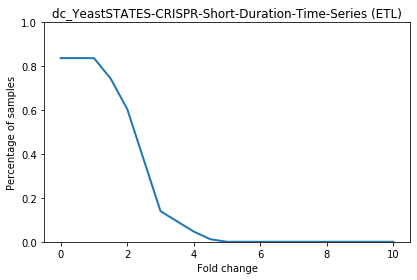

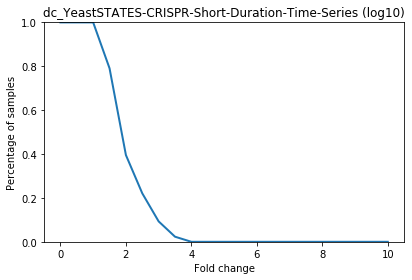

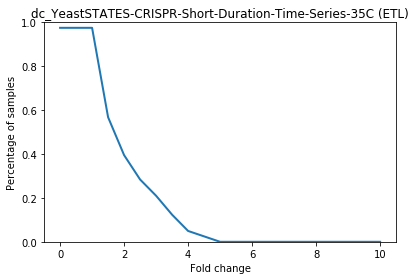

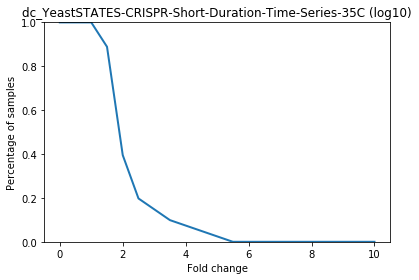

In [10]:
plot_above_threshold(all_summaries)


In [11]:
for r,s in all_summaries.items():
    print(r)
    print(len(s.index))

/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv
86
/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv
86
/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_etl_stats_wasserstein_dists.csv
81
/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_raw_log10_stats_wasserstein_dists.csv
81


In [13]:
all_summaries["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv"]

,wasserstein_min,wasserstein_median,wasserstein_max,sample_ids
"(SpheroControl, 0.0)",NaN,NaN,NaN,[(sample.transcriptic.aq1dvh7dssh7ewe.experime...
"(UWBF_23970, 0.0)",1.037902,NaN,17.432304,[(sample.transcriptic.aq1dvh7dsr67549.experime...
"(UWBF_24864, 0.0)",1.000000,NaN,4.684759,[(sample.transcriptic.aq1dvh7dss4q9g6.experime...
"(UWBF_24926, 0.0)",1.066424,1.623551,4.918705,[(sample.transcriptic.aq1dvh7dsraqwme.experime...
"(UWBF_24926, 4e-06)",1.131755,1.293102,4.698832,[(sample.transcriptic.aq1dvh7dsr6754b.experime...
"(UWBF_24926, 1e-05)",1.170227,1.926206,7.672033,[(sample.transcriptic.aq1dvh7dsr7bb89.experime...
"(UWBF_24926, 2.5e-05)",1.338302,2.534149,7.393770,[(sample.transcriptic.aq1dvh7dsr7bb8b.experime...
"(UWBF_24926, 4e-05)",1.334958,2.963923,5.067718,[(sample.transcriptic.aq1dvh7dsr8fhc9.experime...
"(UWBF_24926, 5.9999999999999995e-05)",1.384359,2.633967,4.320413,[(sample.transcriptic.aq1dvh7dsr8fhcb.experime...
"(UWBF_24926, 8e-05)",1.000000,2.657057,3.916516,[(sample.transcriptic.aq1dvh7dsr9kqga.experime...


In [14]:
all_summaries_over_rep = compute_summary(results_dir_short, meta_files, ["strain","inducer_concentration","well","replicate"], "timepoint", [18.0,24.0])


In [15]:
all_summaries_over_rep["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv"]

,wasserstein_min,wasserstein_median,wasserstein_max,sample_ids
"(SpheroControl, 0.0, f2, 1)",NaN,NaN,NaN,[(sample.transcriptic.aq1dvh7dssh7ewe.experime...
"(SpheroControl, 0.0, f2, 2)",NaN,NaN,NaN,[(sample.transcriptic.aq1dvhcr6e7kkvd.experime...
"(SpheroControl, 0.0, f2, 3)",NaN,NaN,NaN,[(sample.transcriptic.aq1dvmrawdpnxv4.experime...
"(UWBF_23970, 0.0, a2, 1)",1.073113,1.073113,1.073113,[(sample.transcriptic.aq1dvh7dsr67549.experime...
"(UWBF_23970, 0.0, a2, 4)",NaN,NaN,NaN,[(sample.transcriptic.aq1dvhcr6da7nmh.experime...
"(UWBF_23970, 0.0, a2, 7)",3.205273,3.205273,3.205273,[(sample.transcriptic.aq1dvmrawcr5tgb.experime...
"(UWBF_23970, 0.0, g1, 2)",1.049689,1.049689,1.049689,[(sample.transcriptic.aq1dvh7dsspvejk.experime...
"(UWBF_23970, 0.0, g1, 5)",NaN,NaN,NaN,[(sample.transcriptic.aq1dvhcr6ed9khj.experime...
"(UWBF_23970, 0.0, g1, 8)",2.008291,2.008291,2.008291,[(sample.transcriptic.aq1dvmrawdvbxha.experime...
"(UWBF_23970, 0.0, h1, 3)",1.787513,1.787513,1.787513,[(sample.transcriptic.aq1dvh7dssvje7u.experime...


In [16]:
example = all_summaries_over_rep["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv"]
example["sample_ids"][3]

(SpheroControl, 0.0, f2, 1)              [(sample.transcriptic.aq1dvh7dssh7ewe.experime...
(SpheroControl, 0.0, f2, 2)              [(sample.transcriptic.aq1dvhcr6e7kkvd.experime...
(SpheroControl, 0.0, f2, 3)              [(sample.transcriptic.aq1dvmrawdpnxv4.experime...
(UWBF_23970, 0.0, a2, 1)                 [(sample.transcriptic.aq1dvh7dsr67549.experime...
(UWBF_23970, 0.0, a2, 4)                 [(sample.transcriptic.aq1dvhcr6da7nmh.experime...
(UWBF_23970, 0.0, a2, 7)                 [(sample.transcriptic.aq1dvmrawcr5tgb.experime...
(UWBF_23970, 0.0, g1, 2)                 [(sample.transcriptic.aq1dvh7dsspvejk.experime...
(UWBF_23970, 0.0, g1, 5)                 [(sample.transcriptic.aq1dvhcr6ed9khj.experime...
(UWBF_23970, 0.0, g1, 8)                 [(sample.transcriptic.aq1dvmrawdvbxha.experime...
(UWBF_23970, 0.0, h1, 3)                 [(sample.transcriptic.aq1dvh7dssvje7u.experime...
(UWBF_23970, 0.0, h1, 6)                 [(sample.transcriptic.aq1dvhcr6em3saq.experime...